# TL;DR at bottom (look at Linear Regression) <hr>

## Autoregression Models for Time Series Forecasting With Python:
https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.

It is a very simple idea that can result in accurate forecasts on a range of time series problems.

In this tutorial, you will discover how to implement an autoregressive model for time series forecasting with Python.

After completing this tutorial, you will know:

- How to explore your time series data for autocorrelation.
- How to develop an autocorrelation model and use it to make predictions.
- How to use a developed autocorrelation model to make rolling predictions.

<hr>
#### Copy paste from TLDR_make_stationary minus ARIMA

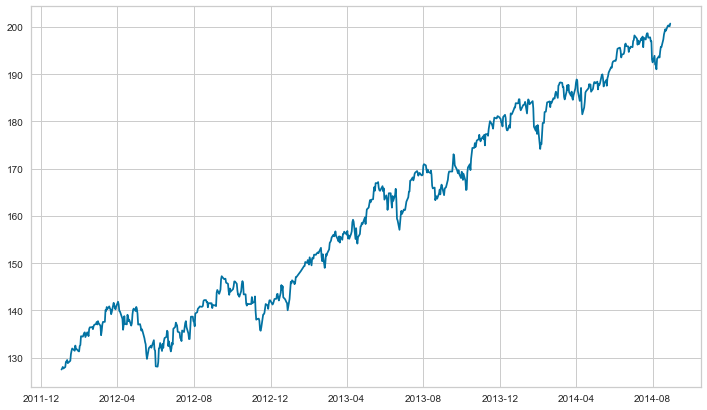

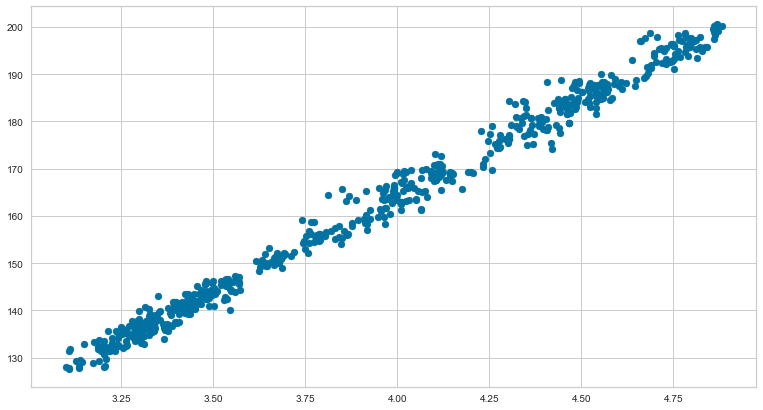

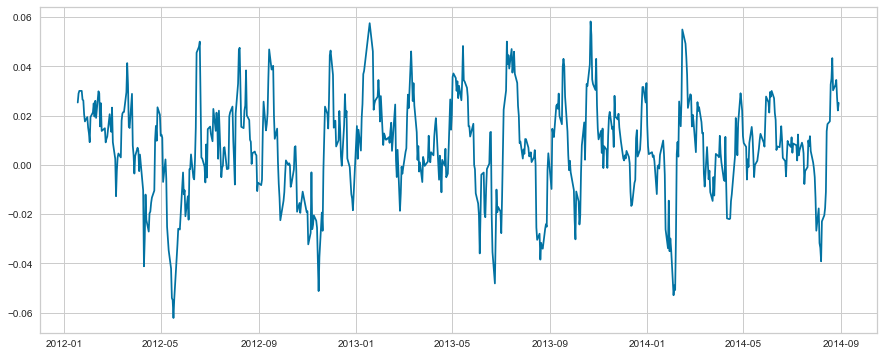

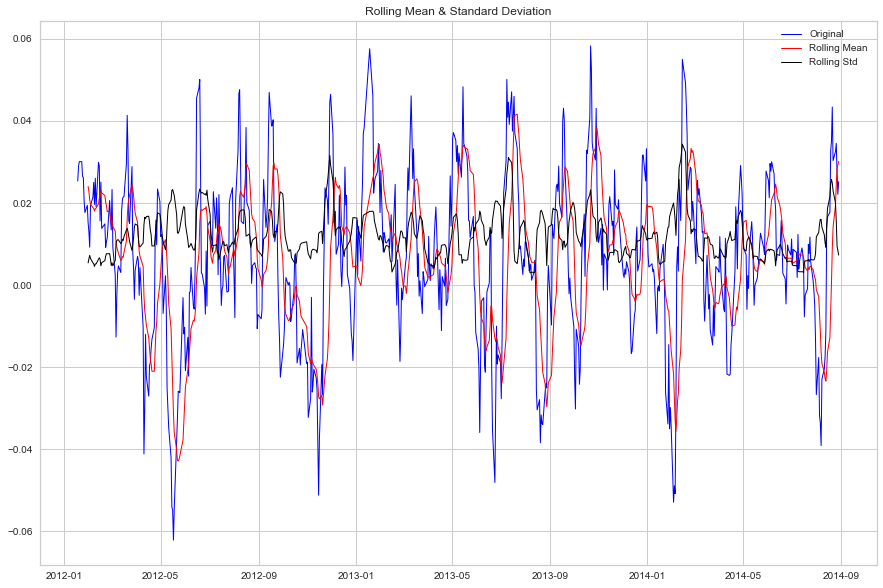

Results of Dickey-Fuller Test:
Test Statistic                  -5.023633
p-value                          0.000020
#Lags Used                      20.000000
Number of Observations Used    636.000000
Critical Value (1%)             -3.440674
Critical Value (5%)             -2.866095
Critical Value (10%)            -2.569196
dtype: float64


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from pandas.core import datetools

from yellowbrick.regressor import ResidualsPlot

# A copy paste from TLDR_make_stationary, excluding ARIMA:

# ------------------------------------------------------ #    

def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window, center=False).mean()
    rolstd = timeseries.rolling(window, center=False).std()
    

    #Plot rolling statistics:
    plt.figure(figsize=(15,10))
    orig = plt.plot(timeseries, color='blue',label='Original', linewidth=1)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=1)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth=1)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
def setup_plot(title, width=15, height=10):
    plt.figure(figsize=(width, height))
    plt.title(title, fontsize=18)
    
    
def plot_residuals(model, x_train, x_test, y_train, y_test):
    visualizer = ResidualsPlot(model)

    visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(x_test, y_test)  # Evaluate the model on the test data
    g = visualizer.poof() 
# ------------------------------------------------------ #    

# I am replacing outliers instead of dropping for sake of window
df = pd.read_csv("stockdata.csv", index_col='date', parse_dates=['date'])

# Replace signal outliers with last observation
sig_val = df['signal'].value_counts()
criteria = df[ (df['signal'] <= 2) | (df['signal'] >= 400) ]
df['signal'][criteria.index] = np.nan
df['signal'].fillna(method='ffill', inplace=True)

# Replace spy_close_price outliers with last observation
sig_val = df['spy_close_price'].value_counts()
criteria = df[ df['spy_close_price'] >= 500 ]
df['spy_close_price'][criteria.index] = np.nan
df['spy_close_price'].fillna(method='ffill', inplace=True)

# ------------------------------------------------------ # 

plt.figure(figsize=(12,7))
plt.plot(df['spy_close_price'])
plt.show()

plt.figure(figsize=(13,7))
plt.scatter(df['signal'], df['spy_close_price'])
plt.show() 

# sliding window size to simulate 2 weeks ( 10 days )
wind=10

# Price log diff is stationary
price_log = np.log(df['spy_close_price'])
price_log_dif = price_log - price_log.shift(periods=wind)
price_log_dif.dropna(inplace=True)

plt.figure(figsize=(15,6))
plt.plot(price_log_dif)
test_stationarity(price_log_dif, wind)

<hr>

### Autoregression 

Models an output value based on a linear combination of input values.
    
    yhat = b0 + b1*x1

Where yhat is the prediction, b0 and b1 are coefficients found by optimizing the model on training data and x is an input value. On a time series, input variables are taken as observations at previous time steps, called lab variables.

For example, predict the value for step (t+1) given the observations at the last two time steps (t-1) and (t-2), then the model would look like:
    
    X(t+1) = b0 + b1*X(t-1) + b2*X(t-2)

Because the regression model uses data from the same input variable at previous time steps, it is referred to as autoregression (regression of self).

### Autocorrelation

An autoregression model makes an assumption that observations at previous steps are useful to predict the next step. This relationship between variables is called correlation.

If both variables change in the same direction, this is called positive correlation. If the variables move in opposite directions, then negative correlattion.

Statistical measures can be used to calculate the correlation between output variable and values at prev. Time steps at various different lags. The stronger the correlation between the output and a specific lagged variable, the more weight that autoregression model will put on that variable. ( more info: [here](http://personal.strath.ac.uk/gary.koop/Oheads_Chapter8.pdf), wish some examples on stock market )

The correlation statistics can help to choose which lag variables will be useful in a model and which will not.

If all lag variables show low or no correlation with the output variable, then it suggests the time series may not be predictable. 

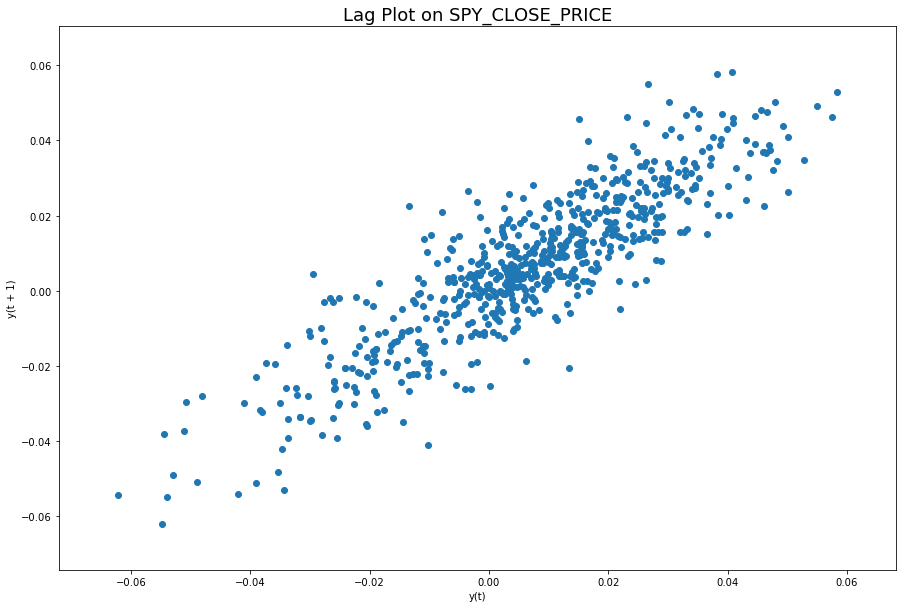

In [4]:
# Using the price_log_dif here

# Check for autocorrelation visually: 
# Plot the observation at previous time step with the
# observation at next time step as a scatter plot.

signal_stat = np.log(df['signal']) - np.log(df['signal']).shift(periods=wind)
signal_stat.dropna(inplace=True)

from pandas.plotting import lag_plot
setup_plot("Lag Plot on SPY_CLOSE_PRICE")
lag_plot(price_log_dif)
plt.show() 

Since there is a large ball of observations along a diagonal line of the plot, there is likely some correlation or relationship.

Another quick check is to directly calculate the correlation between observation and lag variable using the Pearson correlation coefficient. This produces a number to summarize how correlated two variables are between -1 and +1 ( negatively and positively correlated ). Values close to 0 indicate low correlation, absolute values above 0.5 indicate high correlation.

In [5]:
# Not using price_log_dif here, just shifting the price_log
# So bascially, without the differencing?

df_shift = pd.concat([price_log_dif + price_log, price_log], axis=1)
df_shift.columns = ['t-lag','t+lag']
result = df_shift.corr()
print(result)  

          t-lag     t+lag
t-lag  1.000000  0.988578
t+lag  0.988578  1.000000


### Autocorrelation Plots

Plot the correlation coefficient for each lag variable. This aims to give an idea of which lag variables may be good candidates for use in a predictive model and how the relationship between the observation and historic values changes over time.

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines for the 95% and 99%  confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, and this provides a threshold or cutoff for selecting lag values.

### Persistence Model

Say we want to develop a model to predict the last 7 days of minimum temperatures in the dataset given all prior observations.

The simplest model that we could use would be to persist the last observation. We call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

We split the observations into training and test sets, with only the last 7 observations in the datset assigned to the test set as "unseen" data that we wish to predict.

The predictions are made using a walk forward validation model so that we can persist the most recent observations for the next day. So we are making seven 1-day forecasts.

(the site uses 7 days, below is 25 days)

Test MSE: 0.0002746


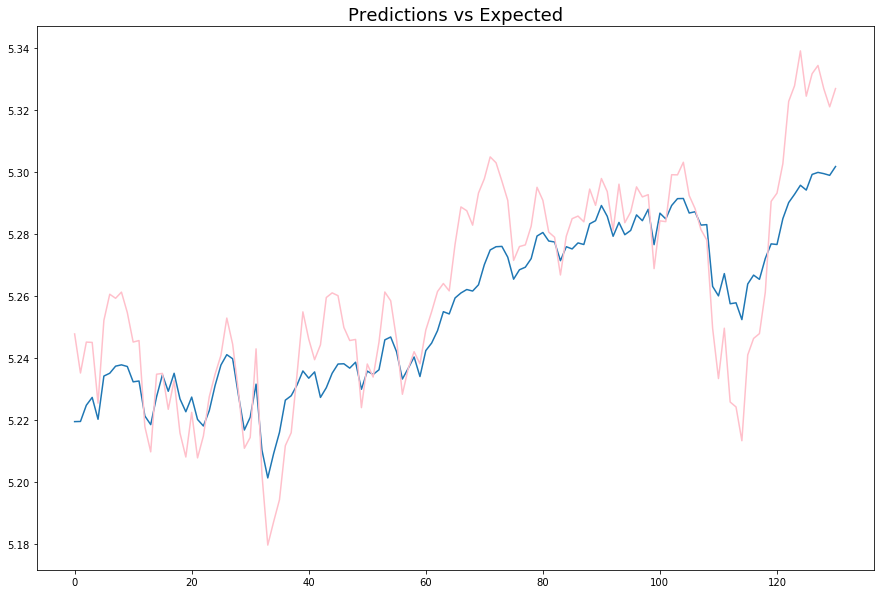

In [6]:
from sklearn.metrics import mean_squared_error

# Note: 5 days = 1 week
predict_days = int(price_log_dif.count()/5) # use 1/5 of our dataset as test

# I have no idea what I'm doing lol.

# Split into train and test sets, 
# we are predicting for approximately a month (25 days)
x = df_shift.values
train, test = x[1:len(x)-predict_days], x[len(x)-predict_days:]
train_x, train_y = train[:,0], train[:,1]
test_x, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk forward validation
predictions = list()
for x in test_x:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.7f' % test_score)

# plot predictions vs expected
setup_plot('Predictions vs Expected')
plt.plot(test_y)
plt.plot(predictions, color='pink')
plt.show()

### AutoRegression Model

An Autoregression Model is a linear regression model that uses lagged variables as input variables. 


The difference between this and the model above is that we are making one "7"-day forecast.


Lag: 19
Coefficients: [ 0.00123282  0.94584988 -0.02700945  0.0158589  -0.08446233  0.04074702
  0.08455263 -0.07902207  0.04796935  0.00098641 -0.53440465  0.44036871
  0.01650354  0.00224563 -0.09794797  0.07865015  0.03676048  0.00721129
 -0.06484874 -0.03384176]
predicted: 0.013641, expected= 0.017738
predicted: 0.020438, expected= 0.032687
predicted: 0.021626, expected= 0.035043
predicted: 0.026602, expected= 0.043384
predicted: 0.020373, expected= 0.030326
predicted: 0.019862, expected= 0.032516
predicted: 0.020275, expected= 0.034533
predicted: 0.020105, expected= 0.027388
predicted: 0.007530, expected= 0.022128
predicted: 0.006958, expected= 0.025176
Test MSE: 0.0001689


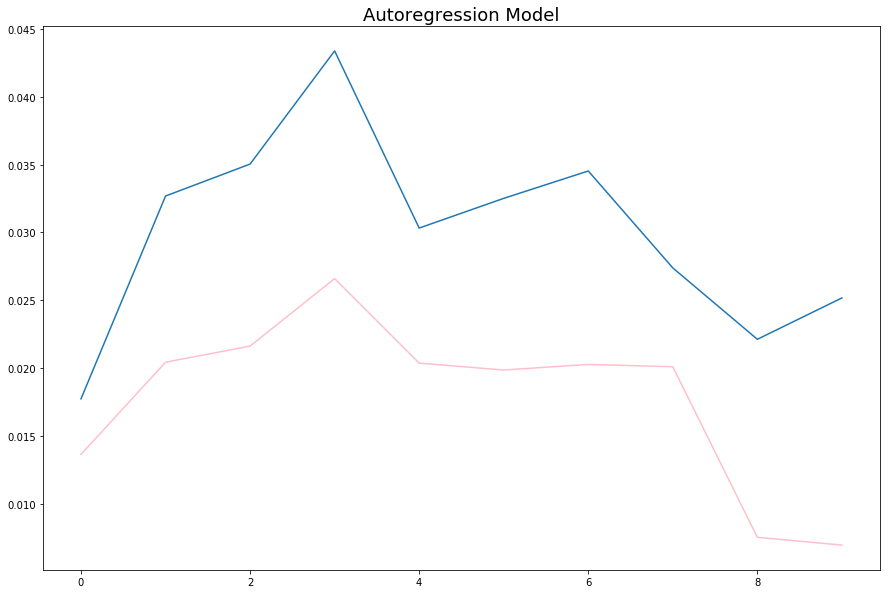

In [7]:
from statsmodels.tsa.ar_model import AR

# Split data set
X = price_log_dif.values
train, test = X[1:len(X)-wind], X[len(X)-wind:]

# Train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# Make predictions
predictions = model_fit.predict(start=len(train),
                               end=len(train)+len(test)-1,
                               dynamic=False)
for i in range( len(predictions) ):
    print('predicted: %f, expected= %f' % (predictions[i],test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.7f' % error)

# plot results
setup_plot("Autoregression Model")
plt.plot(test)
plt.plot(predictions, color='pink')
plt.show()

# lmao the model is so bad and idk what I'm doing because
# This is predicting future prices based on past prices
# but we're suppose to predict them based on signals. 
# help

predicted=0.025959, expected=0.017738
predicted=0.033118, expected=0.032687
predicted=0.047301, expected=0.035043
predicted=0.053294, expected=0.043384
predicted=0.054429, expected=0.030326
predicted=0.037970, expected=0.032516
predicted=0.040427, expected=0.034533
predicted=0.039272, expected=0.027388
predicted=0.019835, expected=0.022128
predicted=0.014079, expected=0.025176
Test MSE: 0.0001231


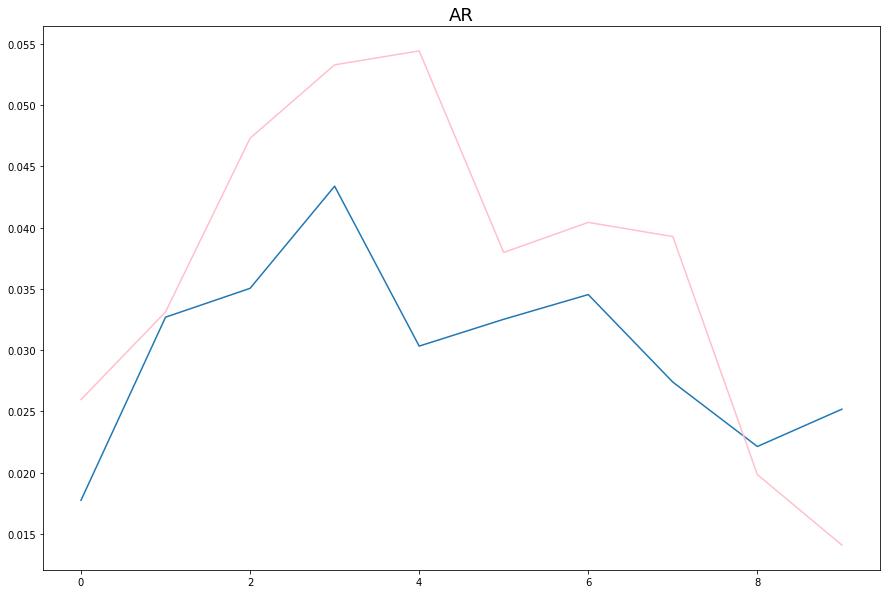

In [8]:
# split dataset
X = price_log_dif.values
xtrain, xtest = X[1:len(X)-wind], X[len(X)-wind:]
# Y = signal_stat # stationary signal
# ytrain, ytest = Y[1:len(X)-wind], Y[len(Y)-wind:]

# train autoregression
model = AR(xtrain)
model_fit = model.fit()
window = wind #wind #model_fit.k_ar
coef = model_fit.params


# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.7f' % error)


# plot
setup_plot("AR")
plt.plot(test)
plt.plot(predictions, color='pink')
plt.show()

<hr>

### ARIMA 
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

- p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very - small.
- q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

#### END OF DUMP

<hr>

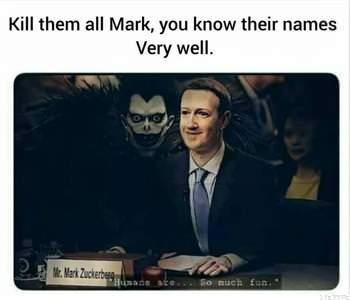

<hr>

# simple linear regression
http://devarea.com/python-machine-learning-example-linear-regression/#.WtztAtPwbUo
.-.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date
import seaborn as sb

Coefficients: 
 [[ 0.66803727]]
Mean squared error: 0.0004366
R-squared = : 0.8893309


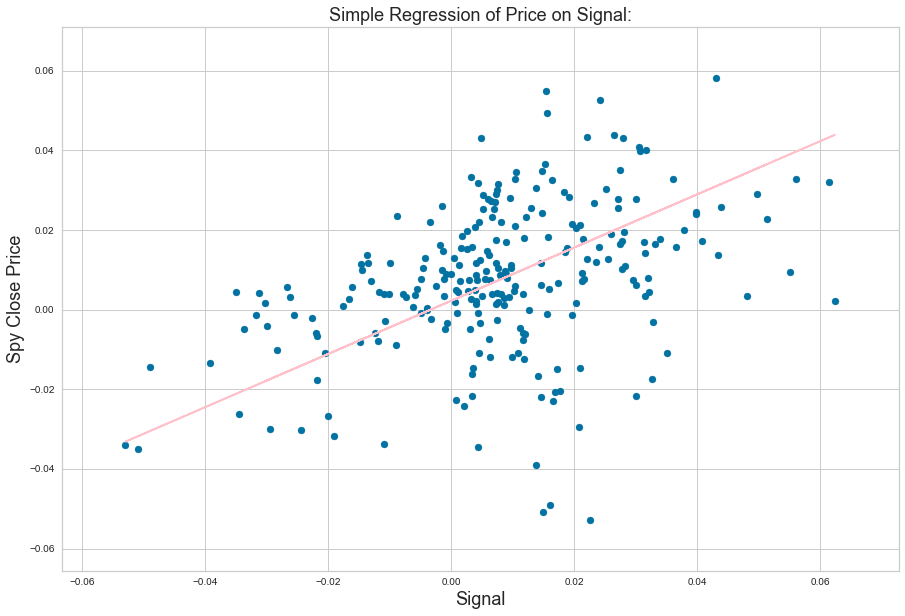

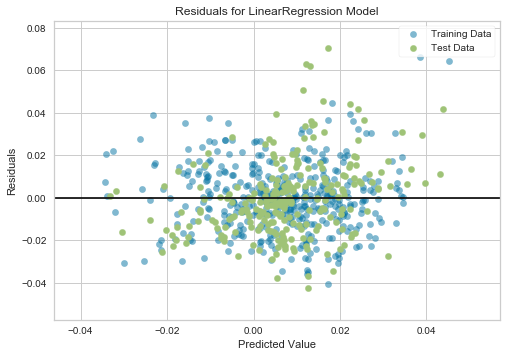

In [39]:
# 1 week ~ 5 days
to_predict = 250 #int(len(price_log_dif)/3)

wind = 10 # Increasing this will increas R^2

# price_shift = price_log - price_log.shift(10)
price_diff2 = np.log(df['spy_close_price']).diff(wind).dropna()
sig_diff2 = np.log(df['signal']).diff(wind).dropna()

# Temp dataframe using the stationary signal and prices
dftemp = pd.concat([sig_diff2, price_diff2], axis=1)
dftemp.dropna(inplace=True)
x = dftemp[['signal']]
y = dftemp[['spy_close_price']]
x_train, x_test = x[:-to_predict], x[-to_predict:]
y_train, y_test = y[:-to_predict], y[-to_predict:]


# Train the model and predict for x_test
lm = LinearRegression()
lm.fit(x_train, y_train)
predicted = lm.predict(x_test)
expected = y_test.values

# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean squared error: %.7f"
      % mean_squared_error(x_test, expected))
# Explained variance score: 1 is perfect prediction
print('R-squared = : %.7f' % r2_score(x_test, predicted))

setup_plot("Simple Regression of Price on Signal:")
plt.scatter(x_test, y_test)
plt.plot(x_test, predicted, color='pink')

plt.xlabel('Signal', fontsize=18)
plt.ylabel('Spy Close Price', fontsize=18)

plt.show()

# Plot the residuals
plot_residuals(LinearRegression(), x_train, x_test, y_train, y_test) 

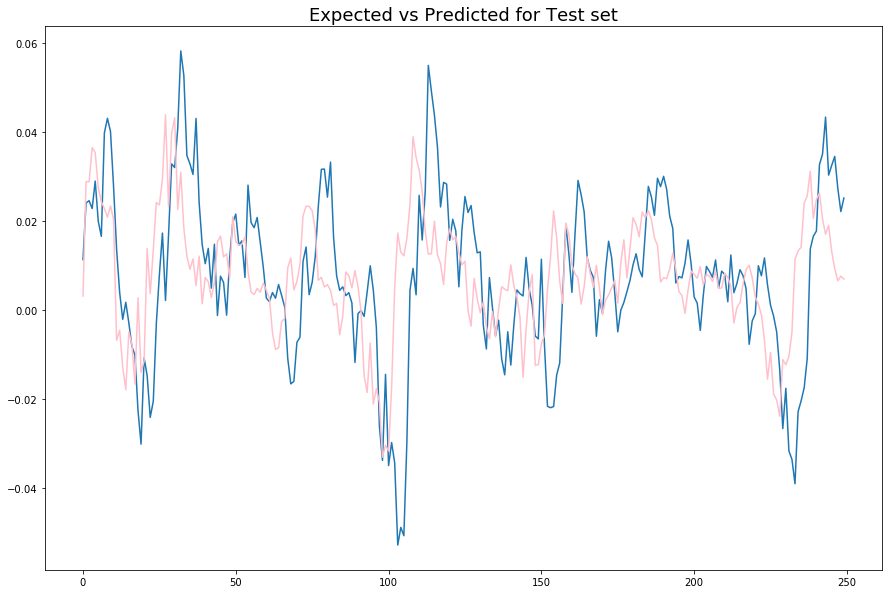

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657 entries, 2012-01-18 to 2014-08-29
Data columns (total 2 columns):
signal             657 non-null float64
spy_close_price    657 non-null float64
dtypes: float64(2)
memory usage: 15.4 KB


In [14]:
# Plotting expected vs predicted
setup_plot("Expected vs Predicted for Test set")
plt.plot(expected)
plt.plot(predicted, color='pink')
plt.show()

dftemp.info()

> The R-squared for 250 days ( approx 50 weeks ) is ok, 88.9% The Professor did mention something about 88.8 but he probably got that from some student and I don't know how many the student used to test. The lag is incorperated into the price_log_dif and signal_stat, both are stationary. 

> Since all data points were kept, but we shifted by 10, there's 657 variables for usage. Which is a something more than 131 weeks. 

> Idk if this is helpful at all, I tried .-. but feel free to change the shifting/lag/stationary thing and such if it gets better results. I'll try the neural networks later or something, but I couldn't figure out how to get ARIMA or autoregression to work on 2 variables. So ended up doing the simplest regression there is.

<hr>

In [ ]:
df.corr() 

In [ ]:
dftemp.corr()

In [ ]:
signal_stat